In [1]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import math
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

F:\Anaconda\location\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 16
dropout = 0.01
epoch=60
#读取数据
df1=pd.read_csv('data.csv') 
df1=df1.iloc[:,2:]
df1.tail()

,open,low,close,high
26272,7.1042,7.1042,7.1048,7.1055
26273,7.1047,7.1038,7.1038,7.1047
26274,7.1039,7.1039,7.1046,7.1047
26275,7.1048,7.1043,7.1045,7.1049
26276,7.1049,7.1049,7.1057,7.1057


In [3]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
input_size=len(df.iloc[1,:])

In [4]:
#构建lstm输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23644, 5, 4) (23644,) (2627, 5, 4) (2627,)


F:\Anaconda\location\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [5]:
#建立LSTM模型 训练
inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘

outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 4)         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 16)        80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1, 16)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 16)        0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
bilstm (Bi

In [6]:
history=model.fit(X_train, y_train, nb_epoch = epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

F:\Anaconda\location\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 23644 samples, validate on 2627 samples
Epoch 1/60
23644/23644 [==============================] - 4s 162us/step - loss: 0.0869 - acc: 4.2294e-05 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 2/60
23644/23644 [==============================] - 1s 29us/step - loss: 0.0592 - acc: 4.2294e-05 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 3/60
23644/23644 [==============================] - 1s 30us/step - loss: 0.0557 - acc: 4.2294e-05 - val_loss: 0.0511 - val_acc: 0.0000e+00
Epoch 4/60
23644/23644 [==============================] - 1s 29us/step - loss: 0.0523 - acc: 4.2294e-05 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 5/60
23644/23644 [==============================] - 1s 31us/step - loss: 0.0487 - acc: 4.2294e-05 - val_loss: 0.0454 - val_acc: 0.0000e+00
Epoch 6/60
23644/23644 [==============================] - 1s 28us/step - loss: 0.0446 - acc: 8.4588e-05 - val_loss: 0.0419 - val_acc: 0.0000e+00
Epoch 7/60
23644/23644 [==============================] - 1s 28us/step - loss: 0

Epoch 56/60
23644/23644 [==============================] - 1s 30us/step - loss: 0.0020 - acc: 8.4588e-05 - val_loss: 1.7346e-04 - val_acc: 0.0000e+00
Epoch 57/60
23644/23644 [==============================] - 1s 28us/step - loss: 0.0019 - acc: 8.4588e-05 - val_loss: 1.5935e-04 - val_acc: 0.0000e+00
Epoch 58/60
23644/23644 [==============================] - 1s 30us/step - loss: 0.0019 - acc: 8.4588e-05 - val_loss: 1.7183e-04 - val_acc: 0.0000e+00
Epoch 59/60
23644/23644 [==============================] - 1s 31us/step - loss: 0.0019 - acc: 8.4588e-05 - val_loss: 1.6112e-04 - val_acc: 0.0000e+00
Epoch 60/60
23644/23644 [==============================] - 1s 30us/step - loss: 0.0019 - acc: 8.4588e-05 - val_loss: 1.7391e-04 - val_acc: 0.0000e+00


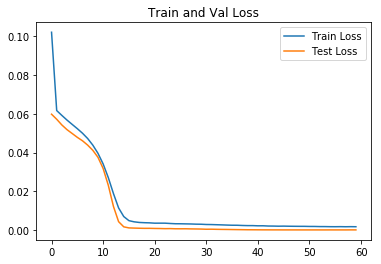

In [7]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

Text(0.5,1,'Train Data')

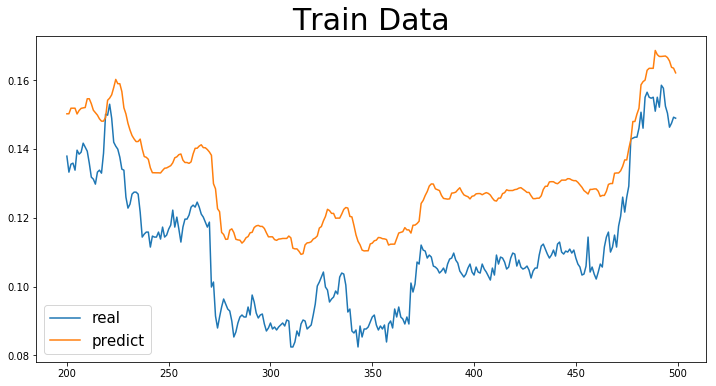

In [8]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5,1,'Test Data')

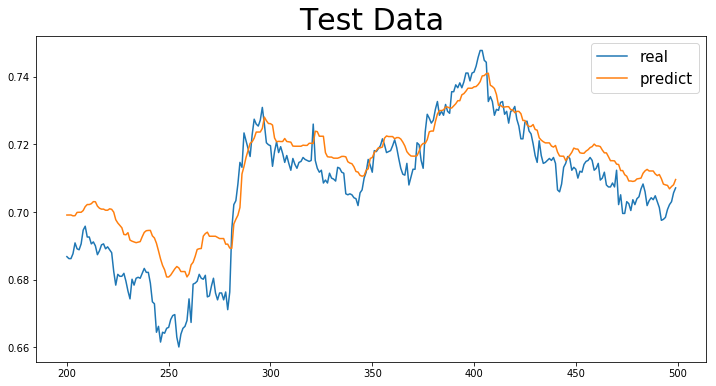

In [9]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [10]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.024356071166775788
0.0009762876353679087
6.014338127336609
0.43560461870321027
测试集上的MAE/MSE/MAPE/涨跌准确率
0.010155834005463554
0.00015539240964995382
1.4232616557473812
0.4044173648134044
